### sindy prediction of the collected data 

First step: Load your necessary libraries for running the code

In [1]:
import numpy as np
import pysindy as ps
from scipy.io import loadmat
from pysindy.differentiation import SmoothedFiniteDifference
from pysindy.differentiation import FiniteDifference
from pysindy.feature_library import polynomial_library
from pysindy.feature_library import custom_library
from pysindy.feature_library import ConcatLibrary
from pysindy.feature_library import identity_library

from sklearn.metrics import mean_squared_error
# from scipy.integrate import solve_ivp
# from scipy.integrate import odeint

# %matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.cm import rainbow

# Integrating the velocity dataset

(125001, 1)
(125001, 1)
(125001, 1)


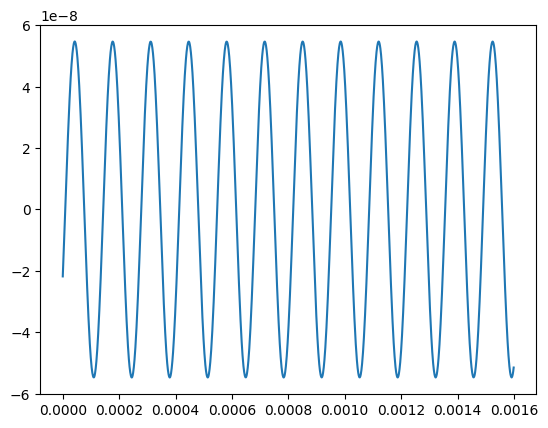

In [2]:
from scipy.integrate import simpson

rec_time = 0.1
#rec_time = 60
sampling_rate = 1250000
start_time = 0
t_array = np.arange(start_time, rec_time, 1/sampling_rate)
t_array = np.array(t_array)
t_array = t_array[:,np.newaxis]

velocity_dataset = loadmat("datasel_7422Hz_Sin_800mSrec_4-40kHzfilter_0.449mA_pointfromtip_2.mat")
velocity_raw  = velocity_dataset["datasel"]
velocity = velocity_raw[:, 1]
velocity = np.array(velocity)
velocity = velocity[:,np.newaxis]


#displacement = simpson(velocity, t_array)
def calculate_displacement(velocity, sampling_rate):
    displacement_initial = []
    for i in range(len(velocity)):
        displacement = velocity[i] * (1/sampling_rate)
        displacement_initial = np.append(displacement_initial, displacement)
    
    return displacement_initial

displacement_initial = calculate_displacement(velocity, sampling_rate)

displacement = np.array(displacement_initial)
displacement = displacement[:,np.newaxis]

print(displacement.shape)
print(velocity.shape)
print(t_array.shape) 

#plt.plot(velocity)
plt.plot(t_array[:2000, 0], displacement[:2000, 0])

In [181]:
np.savetxt('integrated displacement for 0.449mA', displacement) # save the variable to a file

(125001, 1)


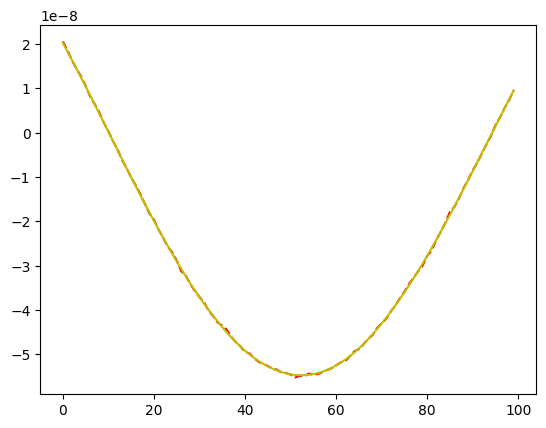

In [179]:
""" # # Parameters for white noise
# mean = 0  # Mean of the Gaussian distribution (zero for white noise)
# std_dev = 0.001  # Adjust the standard deviation as needed to control the amount of noise

# # Adding white noise (corrected version)
# noise = np.random.normal(loc=mean, scale=std_dev, size=displacement.shape)
# displacement_noisy = displacement + noise

#adding noise to sine signal
percentage =0.00002
noise = np.random.normal(0, 0.00001, displacement.shape)*percentage
displacement_noisy = displacement + noise

plt.plot(displacement_noisy[40000:40100, 0], 'r--')
plt.plot(displacement[40000:40100, 0],  'y')
print(displacement_noisy.shape) """

Loading the data

In [3]:
rec_time = 0.1
# #rec_time = 60
sampling_rate = 1250000
start_time = 0
t_array = np.arange(start_time, rec_time, 1/sampling_rate)

# data_file_distance = loadmat("sine_laser_filtered.mat") 
# distance_raw  = data_file_distance["low_filtered"]
# read_out_raw = distance_raw[:, 0]

t_array = np.array(t_array)
t_array= t_array[:,np.newaxis]
# read_out_raw = np.array(read_out_raw)
# read_out_raw = read_out_raw[:,np.newaxis]


""" interval1 = 20
t_train = t_train[::interval1]
interval = 20
x_rec = x_rec[::interval] """

x_rec = displacement[46001:52001]
t_train = t_array[46001:52001]

print(t_train.shape)
print(x_rec.shape)
# print(data_file)
print(t_array.shape)
print(displacement.shape)

(6000, 1)
(6000, 1)
(125001, 1)
(125001, 1)


Saving t_train in a text file for using in MATLAB to solve the generated equation

Smooth the Data and Decompose the assumed 2nd order ODE system into two first order ODE 

(6000, 3)
(6000, 1)
(6000, 1)


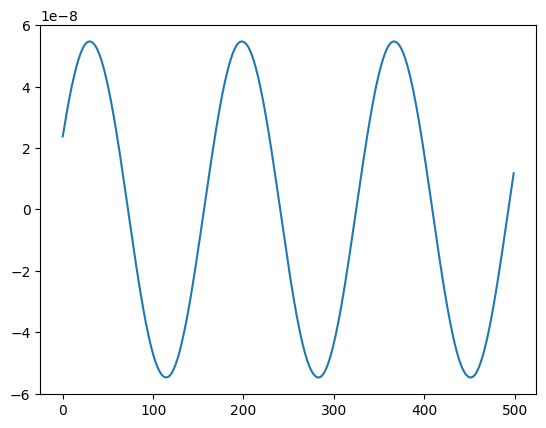

In [4]:
#Trying out different differentiators

#x_rec =np.abs(signal_filtered)

#fd = FiniteDifference(drop_endpoints=True)
sfd = SmoothedFiniteDifference(smoother_kws={'window_length': 5} )
#sfd = SmoothedFiniteDifference()
#diff = ps.SINDyDerivative(kind="trend_filtered", order=1, alpha=1e-3)

#xdot = fd._differentiate(x_rec, t_train)
xdot = sfd._differentiate(x_rec, t_train[:, 0])
#xdot = diff._differentiate(x_rec,t_train)

#data_x_train = x_rec

#data_x_train = np.hstack((x_rec, xdot))
data_x_train = np.hstack((x_rec, xdot, t_train))

print(data_x_train.shape)
print(t_train.shape)
print(xdot.shape)
plt.plot(x_rec [:500, 0])

Lets fit the model and build the necessary library to represent the dynamics of your system

1.(a): Polynomial+ Fourier Library

In [8]:
""" poly_order = 1
max_iter = 10000

#for STLSQ
threshold = 0.3  # optimized value = 0.3 if polyorder=1
regularization_on_weight = 0.09    # default is 0.05

#variable thresholding for SR3 optimizers
thresholds = 0.05* np.ones((5, 2))
thresholds[2:, :] = 0.1  #  Determines the strength of the regularization. When the regularization function R is the L0 norm, the regularization is equivalent to performing hard thresholding, and lambda is chosen to threshold at the value given by this parameter. This is equivalent to choosing lambda = threshold^2 / (2 * nu).
nu = 2 #Determines the level of relaxation. Decreasing nu encourages w and v to be close, whereas increasing nu allows the regularized coefficients v to be farther from w.
tol = 0.00001 #for determining convergence

#sr3 = ps.SR3(thresholder="weighted_l0", thresholds=thresholds, max_iter=max_iter, nu=nu, tol=tol)
stlsq =ps.STLSQ(alpha=regularization_on_weight, threshold=threshold, max_iter=max_iter)

lib_poly = ps.feature_library.PolynomialLibrary(degree = poly_order)
lib_fourier = ps.feature_library.FourierLibrary(n_frequencies = 1, include_sin=False, include_cos=True)

functions = [lambda x:x,
             lambda x,y : np.cos(x * y)
]
function_names = [lambda x : x,
                  lambda x,y : 'cos(' + x +', ' + y +')'
    
]
lib_custom = ps.CustomLibrary(library_functions = functions, function_names=function_names)

model_sine=ps.SINDy(
    optimizer=stlsq,
    #optimizer=sr3,
    differentiation_method= sfd,
    feature_names=["x", "xdot"],
    discrete_time=False,
    feature_library=ps.feature_library.ConcatLibrary([lib_poly, lib_fourier])
    )

model_sine.fit(data_x_train, 1/sampling_rate)
model_sine.print()
model_sine.get_feature_names() """

(x)' = 1.000 xdot
(xdot)' = -1122841.793 1 + -2173836879.325 x + -1.324 xdot + 1390158.087 cos(1 x) + -486671.766 cos(1 xdot)


['1', 'x', 'xdot', 'cos(1 x)', 'cos(1 xdot)']

In [161]:
x_rec_noisy = displacement_noisy[46001:52001]
print(x_rec_noisy.shape)
xdot_noisy = sfd._differentiate(x_rec_noisy, t_train[:, 0])
print(xdot_noisy.shape)
data_x_train_noisy = np.hstack((x_rec_noisy, xdot_noisy, t_train))
print(data_x_train_noisy.shape)

(6000, 1)
(6000, 1)
(6000, 3)


1(b) Generalized Library

In [5]:
import numpy as np

poly_order = 3
max_iter = 10

# for STLSQ
regularization_on_weight = 0.05
threshold = 0.2

#variable thresholding for SR3 optimizers
# thresholds = 0.05* np.ones((11, 3))
# thresholds[2 :, :] = 0.5
# nu = 0.3
# tol= 0.00001

#ensemble_optimizer = ps.EnsembleOptimizer(ps.STLSQ(threshold=threshold, alpha=regularization_on_weight, normalize_columns=False, max_iter=max_iter), bagging=True, replace=False, n_subset=1000, n_models=6, ensemble_aggregator=np.median)
stlsq = ps.STLSQ(threshold=threshold, max_iter=max_iter, alpha=regularization_on_weight)
#sr3 = ps.SR3(thresholder="weighted_l0", thresholds=thresholds, max_iter=max_iter, nu=nu, tol=tol)

#Initialize Libraries

#lib_poly = ps.feature_library.PolynomialLibrary(degree = poly_order, include_interaction=False, include_bias=False)

#lib_fourier = ps.feature_library.FourierLibrary(n_frequencies = 1, include_cos=False, include_sin=True)

funct = [lambda x : x,
         lambda x : x ** 3 ,
         #lambda x,y : (x* y)
        ]

names = [lambda x : '(' + x + ')',
         lambda x : '(' + x + '^' '3' ')',
         #lambda x, y : '(' + x + '*' + y + ')'
         ]
lib_xdot = ps.CustomLibrary(library_functions=funct, function_names=names)

lib_id = ps.IdentityLibrary()

functions = [lambda x :  np.cos(x * 7420),
            lambda x :  np.cos(x * 14840),
            lambda x :  np.cos(x * 22270),
            lambda x :  np.cos(x * 29680),
            lambda x :  np.cos(x * 37090),
            # lambda x :  np.cos(x * 9648),
            # lambda x :  np.cos(x * 10389),
            # lambda x :  np.cos(x * 11880),
            # lambda x :  np.cos(x * 13362),
            # lambda x :  np.cos(x * 14095),
            # lambda x :  np.cos(x * 14837),
            ]

function_names = [lambda x : 'cos(' + x + '*' '7420' ')',
                  lambda x : 'cos(' + x + '*' '14840' ')',
                  lambda x : 'cos(' + x + '*' '22270' ')',
                  lambda x : 'cos(' + x + '*' '29680' ')',
                  lambda x : 'cos(' + x + '*' '37090' ')',
                #   lambda x : 'cos(' '12590', '*', + x + ')',
                #   lambda x : 'cos(' '15100', '*', + x+ ')'
                    ]

lib_custom = ps.CustomLibrary(library_functions=functions, function_names=function_names)
 
inputs_per_library = [[0, 0, 1],  [2, 2, 2]]

inputs_per_library = np.reshape(inputs_per_library, (2, 3))

# Tensor all the polynomial and Fourier library terms together
tensor_array = [[0, 1, 1]]

generalized_library = ps.GeneralizedLibrary([lib_xdot, lib_custom], 
                                            #tensor_array=tensor_array,
                                            #exclude_libraries=[1],
                                            inputs_per_library=inputs_per_library)

model_sine=ps.SINDy(
    optimizer=stlsq,
    #optimizer=ensemble_optimizer,
    #optimizer=sr3,
    differentiation_method= sfd,
    feature_names=["x", "xdot", "t"],
    discrete_time=False,
    feature_library=generalized_library
    
    )
model_sine.fit(data_x_train, 1/sampling_rate)
#model_sine.fit(data_x_train_noisy, 1/sampling_rate)
#model_sine.fit(data_x_train, 1/sampling_rate, ensemble=True, replace=False, n_subset=500, n_models=6, quiet=True, unbias=True, ensemble_aggregator=np.median)
model_sine.print(lhs=['dx/dt', 'd(xdot)/dt', 'dt/dt'])
#ensemble_coefs = model_sine.coef_list
model_sine.get_feature_names()

dx/dt = 1.000 (xdot)
d(xdot)/dt = -2174198397.354 (x) + -2.490 (xdot) + 0.012 cos(t*7420) + -0.002 cos(t*14840) + -0.014 cos(t*22270) + -0.018 cos(t*29680) + -0.013 cos(t*37090)
dt/dt = -4.753 (xdot)


['(x)',
 '(xdot)',
 '(x^3)',
 '(xdot^3)',
 'cos(t*7420)',
 'cos(t*14840)',
 'cos(t*22270)',
 'cos(t*29680)',
 'cos(t*37090)']

# Plotting force-deflection characteristics

(85001, 1)
5.4745984e-08


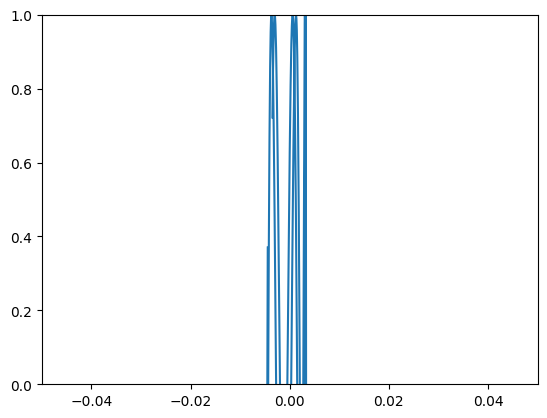

In [6]:
t = t_array[40000:, 0]
stable_signal = displacement[40000:, 0]
F = 0.012 * np.cos(t*7420)/(7420**2 * np.max(stable_signal)) -0.002  * np.cos(t*14840)/(7420**2 * np.max(stable_signal))
-0.014  * np.cos(t*22270)/(7420**2 * np.max(stable_signal))- 0.018* np.cos(t*29680)/(7420**2 * np.max(stable_signal)) - -0.013 * np.cos(t*37090)/(7420**2 * np.max(stable_signal))
F = F[:, np.newaxis]
print(F.shape)
y = stable_signal/np.max(stable_signal)
y = y[:, np.newaxis]
plt.figure()
plt.xlim(-0.05, 0.05)
plt.ylim(0, 1)
plt.plot(F[6001:7001], y[0:1000, 0])
print(np.max(stable_signal))

(85001, 1)
(85001, 1)


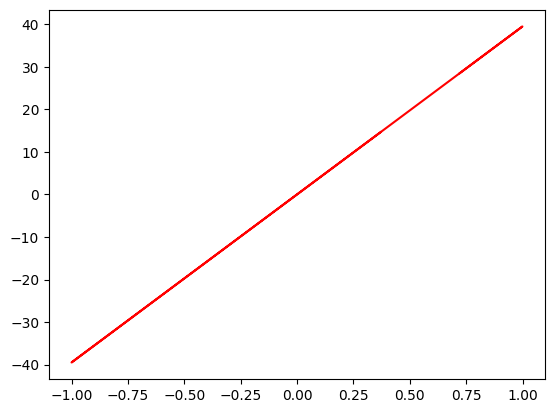

In [11]:
x_nd = stable_signal/np.max(stable_signal)
x_nd = x_nd[:, np.newaxis]

F_stiffness = (2174198397.354 *(x_nd ))/(7420 ** 2)

print(F_stiffness.shape)
print(x_nd.shape)
stiffness = np.hstack((F_stiffness, x_nd))

plt.plot(x_nd[:1000, 0],F_stiffness[:1000, 0], 'r')
#plt.xlim(-0.003, 0.003)
np.savetxt('stiffness_displacement.txt', stiffness) 

(1000, 1)


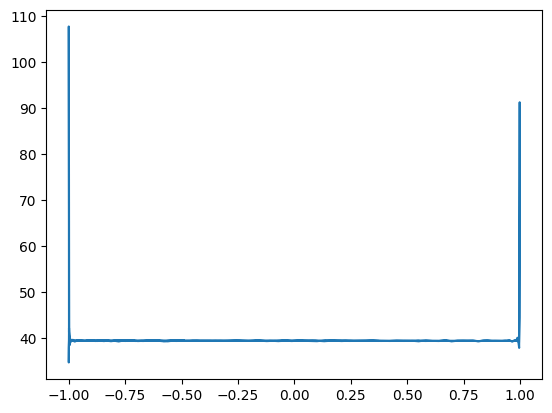

In [24]:
potential_energy = sfd._differentiate(F_stiffness[:1000, 0], x_nd[:1000, 0])
potential_energy = potential_energy[:, np.newaxis]
print(potential_energy.shape)
x_pot = x_nd[:1000, 0]
x_pot = x_pot[:, np.newaxis]
plt.plot(x_nd[:250, 0], potential_energy[:250, 0])
potential = np.hstack((potential_energy, x_pot))
np.savetxt('potential_disp.txt', potential)

In [187]:
x = xdot[4:5, 0]
#t = t_train [2:3, 0]
z = -4.753 * x
print(z)

[-0.01014458]


Post-processing for 'Ensembling' : Weighted average of the coefficients, with weights corresponding to the mean-squared error with the testing set

In [7]:
""" # function to compute the average of the coefficients, weighted by the MSE on the test data.

dt = 1/sampling_rate

def weighted_coefficient_average(coef_list, x_test, dt, optimizer):
    mse = np.zeros(np.shape(coef_list)[0])
    for i in range(np.shape(coef_list)[0]):
        optimizer.coef_ = np.asarray(coef_list)[i, :, :]
        mse[i] = model_sine.score(x_test, t=dt, metric=mean_squared_error)
    avg = np.average(coef_list, axis=0, weights=mse)
    coef_subtracted = np.zeros(np.shape(coef_list))
    for i in range(np.shape(coef_list)[0]):
        coef_subtracted[i, :, :] = np.asarray(coef_list)[i, :, :] - avg
    std = np.sqrt(np.average(coef_subtracted ** 2, axis=0, weights=mse))
    return avg, std

x_rec_test = read_out[43000 : 45000]
xdot_test = xdot_whole[43000 : 45000]
t_test = t_array[43000 : 45000]
t_test = np.array(t_test)
t_test= t_test[:,np.newaxis]
x_test = np.hstack((x_rec_test, xdot_test, t_test))

e_wavg, e_wstd = weighted_coefficient_average(
    ensemble_coefs, x_test, dt, ensemble_optimizer
)
# l_wavg, l_wstd = weighted_coefficient_average(
#     library_ensemble_coefs, x_test, dt, library_ensemble_optimizer
# ) 

# function to zero out any short-term unstable models 

def integration_metric(coef_list, optimizer):
    
    # Try 5 test trajectories
    
    batch_size = 2000
    number_batches = 5
    
    for k in range(number_batches):
        
        start_index = k * batch_size + 43000
        end_index = start_index +batch_size
        
        x_rec_test = read_out[start_index : end_index]
        xdot_test = xdot_whole[start_index : end_index]
        t_test = t_array[start_index : end_index]
        t_test = np.array(t_test)
        t_test= t_test[:,np.newaxis]
        
        data_x_test = np.hstack((x_rec_test, xdot_test, t_test))
        
        for i in range(np.shape(coef_list)[0]):
            optimizer.coef_ = coef_list[i, :, :]
            x_test_sim = model_sine.simulate(data_x_test[0], t_test [:, 0], integrator="odeint")
            if np.any(np.abs(x_test_sim) > 5000):
                # print('unstable model!')
                coef_list[i, :, :] = 0.0
    return coef_list



stable_ensemble_coefs = integration_metric(
    np.asarray(ensemble_coefs), ensemble_optimizer
)
# stable_library_ensemble_coefs = integration_metric(
#     np.asarray(library_ensemble_coefs), library_ensemble_optimizer
# ) """

' # function to compute the average of the coefficients, weighted by the MSE on the test data.\n\ndt = 1/sampling_rate\n\ndef weighted_coefficient_average(coef_list, x_test, dt, optimizer):\n    mse = np.zeros(np.shape(coef_list)[0])\n    for i in range(np.shape(coef_list)[0]):\n        optimizer.coef_ = np.asarray(coef_list)[i, :, :]\n        mse[i] = model_sine.score(x_test, t=dt, metric=mean_squared_error)\n    avg = np.average(coef_list, axis=0, weights=mse)\n    coef_subtracted = np.zeros(np.shape(coef_list))\n    for i in range(np.shape(coef_list)[0]):\n        coef_subtracted[i, :, :] = np.asarray(coef_list)[i, :, :] - avg\n    std = np.sqrt(np.average(coef_subtracted ** 2, axis=0, weights=mse))\n    return avg, std\n\nx_rec_test = read_out[43000 : 45000]\nxdot_test = xdot_whole[43000 : 45000]\nt_test = t_array[43000 : 45000]\nt_test = np.array(t_test)\nt_test= t_test[:,np.newaxis]\nx_test = np.hstack((x_rec_test, xdot_test, t_test))\n\ne_wavg, e_wstd = weighted_coefficient_aver

Plot bagging, bragging, and other post-processing results with error bars

In [8]:

""" coef_types = [np.mean(ensemble_coefs, axis=0), 
              np.median(ensemble_coefs, axis=0),
              np.mean(stable_ensemble_coefs, axis=0), 
             ]
coef_stds = [np.std(ensemble_coefs, axis=0), 
             np.std(ensemble_coefs, axis=0), 
             np.std(stable_ensemble_coefs, axis=0), 
            ]

# define some plotting needs

colors = ['b', 'r', 'k']
props = dict(boxstyle='round', facecolor='wheat', alpha=1.0)
textstrs = ['bagging', 'bragging', 'weighted\nbagging', 
            'stability\nweighted\nbagging']
plt.figure(figsize=(16, 9))

# Loop over the different post-processed coefficients
for k, coefs in enumerate(coef_types):
    coef_std = coef_stds[k]
    plt.subplot(4, 2, k + 1)
    for i in range(coefs.shape[0]):
        plt.errorbar(range(coefs.shape[1]), coefs[i, :], yerr=coef_std[i, :], 
                     fmt='o', color=colors[i], 
                     label='$\dot ' + feature_names[i] + '_{}$' + ' coefficients')
    ax = plt.gca()
    ax.set_xticks(range(10))
    if k >= 6:
        xticknames = model.get_feature_names()
        for i in range(10):
            xticknames[i] = '$' + xticknames[i] + '$'
        ax.set_xticklabels(xticknames, verticalalignment='top', fontsize=28)
    else:
        ax.set_xticklabels([])
    plt.ylim(-20, 35)
    if k == 0:
        plt.legend(fontsize=18, framealpha=1.0, loc='upper right')
        ax.text(0.38, 1.15, 'ensemble', transform=ax.transAxes, 
                fontsize=20, bbox=props)
    if k == 1:
        ax.text(0.35, 1.15, 'library ensemble', transform=ax.transAxes, 
                fontsize=20, bbox=props)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.grid(True)
    ax.set_yticks([-20, -10, 0, 10, 20, 30])
    if k % 2 == 0:
        textstr = textstrs[k // 2]
        ax.text(-0.35, 0.4, textstr, transform=ax.transAxes, 
                fontsize=20, bbox=props)
    else:
        ax.set_yticklabels([]) """

" coef_types = [np.mean(ensemble_coefs, axis=0), \n              np.median(ensemble_coefs, axis=0),\n              np.mean(stable_ensemble_coefs, axis=0), \n             ]\ncoef_stds = [np.std(ensemble_coefs, axis=0), \n             np.std(ensemble_coefs, axis=0), \n             np.std(stable_ensemble_coefs, axis=0), \n            ]\n\n# define some plotting needs\n\ncolors = ['b', 'r', 'k']\nprops = dict(boxstyle='round', facecolor='wheat', alpha=1.0)\ntextstrs = ['bagging', 'bragging', 'weighted\nbagging', \n            'stability\nweighted\nbagging']\nplt.figure(figsize=(16, 9))\n\n# Loop over the different post-processed coefficients\nfor k, coefs in enumerate(coef_types):\n    coef_std = coef_stds[k]\n    plt.subplot(4, 2, k + 1)\n    for i in range(coefs.shape[0]):\n        plt.errorbar(range(coefs.shape[1]), coefs[i, :], yerr=coef_std[i, :], \n                     fmt='o', color=colors[i], \n                     label='$\\dot ' + feature_names[i] + '_{}$' + ' coefficients')\n   

In [9]:
print(data_x_train[0])

[1.70681350e+00 3.17011819e+04 3.20000000e-02]


Defining Test_set to evaluate model stability

In [6]:
#validation 100001:103001. test_set varies (102k-105k)
x_test = displacement[100001:103001]
t_test = t_array[100001:103001]
# t_test = np.array(t_test)
# t_test = t_test[:,np.newaxis]

xdot_test = sfd._differentiate(x_test, t_test[:, 0])
data_x_train_test = np.hstack((x_test, xdot_test, t_test))
print(data_x_train_test.shape)

(3000, 3)


# Plotting Learning curve

In [48]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import r2_score


# # Step 3: Initialize arrays to store performance metric
# train_metric = []
# val_metric = []

# # Step 4: Loop over the desired number of iterations
# num_iterations = 100
# for i in range(1, num_iterations+1):
#     # Train the model on the training set
#     model_sine.fit(data_x_train, 1/sampling_rate)
    
#     # Evaluate performance on the training set
#     y_train_pred = model_sine.simulate(np.array(data_x_train[0]), t_train[:,0]) 
#     train_accuracy = r2_score(x_rec[:, 0], y_train_pred[:,0])
#     train_accuracy = "{:.4f}".format(train_accuracy)
    
#     # Evaluate performance on the validation set
#     y_val_pred = model_sine.simulate(np.array(data_x_train_test[0]), t_test[:,0]) 
#     val_accuracy = r2_score(data_x_train_test[:, 0], y_val_pred[:,0])
#     val_accuracy = "{:.4f}".format(val_accuracy)
    
#     # Store the performance metric
#     train_metric.append(train_accuracy)
#     val_metric.append(val_accuracy)

# # Step 5: Plot the learning curve
# plt.plot(range(1, num_iterations+1), train_metric, label='Training Set')
# plt.plot(range(1, num_iterations+1), val_metric, label='Validation Set')
# plt.xlabel('Number of Iterations')
# plt.ylabel('Performance Metric')
# plt.title('Learning Curve')
# plt.legend()
# plt.show()

Now , Simulate the discovered model forward in time providing the initial condition.

In [7]:
#Training evaluation 
sim = model_sine.simulate(np.array(data_x_train[0]), t_train[:,0]) 

#sim_noisy = model_sine.simulate(np.array(data_x_train_noisy[0]), t_train[:,0]) 

# #Model stability evaluation
# sim = model_sine.simulate(np.array(data_x_train_test[0]), t_test[:,0]) 

sim.shape
#sim_noisy.shape

(6000, 3)

In [9]:
np.savetxt('simulated_final_disp.txt', sim)

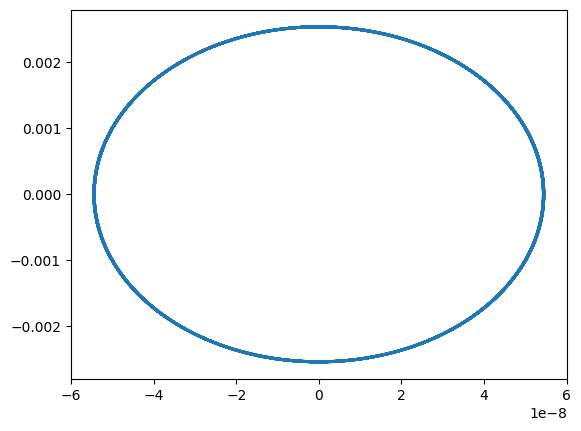

In [8]:
plt.plot(sim[:, 0], sim[:, 1])

# Evaluating error and R2_score

In [167]:
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

# R2_score_train = r2_score(data_x_train[:, 1], sim[:, 1])
# R2_score_train = "{:.3f}".format(R2_score_train)
Pearson_correlation_train = pearsonr(data_x_train[:, 0], sim[:, 0])
Pearson_correlation_train_noisy = pearsonr(data_x_train_noisy[:, 0], sim_noisy[:, 0])
Pearson_correlation_train = "{:.3f}".format(Pearson_correlation_train[0])

#print(f"The observed R2_score for the training_set is:",R2_score_train)
print(f"The Pearson_correlation for the training_set is :", Pearson_correlation_train)
print(f"The Pearson_correlation for the noisy training_set is :", Pearson_correlation_train_noisy)

# R2_score_test = r2_score(data_x_train_test[:, 0], sim[:, 0])
# R2_score_test = "{:.3f}".format(R2_score_test)
# Pearson_correlation_test = pearsonr(data_x_train_test[0:, 0], sim[:, 0])
# Pearson_correlation_test = "{:.3f}".format(Pearson_correlation_test[0])

# print(f"The observed R2_score for the validation set is:",R2_score_test)
# print(f"The Pearson_correlation for the validation set is :", Pearson_correlation_test )

The Pearson_correlation for the training_set is : 1.000
The Pearson_correlation for the noisy training_set is : PearsonRResult(statistic=0.9979394803693482, pvalue=0.0)


# Plotting the evaluation

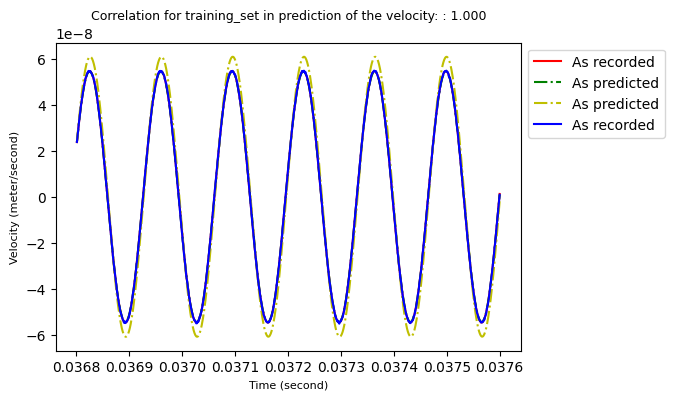

In [169]:
fig,ax = plt.subplots(1,1, figsize=(6,4))
#ax.set_ylabel('Displacement (meter)', fontsize=8)
ax.set_ylabel('Velocity (meter/second)', fontsize=8)
ax.set_xlabel('Time (second)', fontsize=8)

#ax.set_title(f'R2_score for training is : {R2_score_train} ')
ax.set_title(f'Correlation for training_set in prediction of the velocity: : {Pearson_correlation_train}',fontsize=9)

plt.plot( t_train[0:1000 ,0], data_x_train[0:1000, 0], 'r', label="As recorded")
plt.plot( t_train[0:1000, 0], sim[0:1000, 0], 'g-.',  label="As predicted")
plt.plot( t_train[0:1000, 0], sim_noisy[0:1000, 0], 'y-.',  label="As predicted")
plt.plot( t_train[0:1000 ,0], data_x_train_noisy[0:1000, 0], 'b', label="As recorded")

# #ax.set_title(f'R2_score for validation_set is : {R2_score_test} ')
# ax.set_title(f'Correlation for validation_set in prediction of the displacement: {Pearson_correlation_test}', fontsize=9)

# plt.plot( t_test[0:, 0], data_x_train_test[0:, 0], 'r', label="As recorded")
# plt.plot( t_test[0:, 0], sim[0:, 0], 'g--',  label="As predicted")

ax.legend(loc='upper left',  bbox_to_anchor=(1.0005, 1))

# 2. Optimizing Threshold value

In [9]:
# Make coefficient plot for threshold scan
def plot_pareto(coefs, opt, model, threshold_scan, x_test, t_test):
    dt = 1/sampling_rate
    mse = np.zeros(len(threshold_scan))
    mse_sim = np.zeros(len(threshold_scan))
    for i in range(len(threshold_scan)):
        opt.coef_ = coefs[i]
        mse[i] = model.score(x_test, t=dt, metric=mean_squared_error)
        x_test_sim = model.simulate(x_test[0], t_test[:,0], integrator="odeint")
        # if np.any(x_test_sim > 1e4):
        #     x_test_sim = 1e4
        mse_sim[i] = np.sum((x_test[:,0] - x_test_sim[:, 0]) ** 2)
    
    plt.figure()
    plt.semilogy(threshold_scan, mse, "ro")
    plt.semilogy(threshold_scan, mse, "g")
    plt.title(" Effect of threshold value on xdot")
    plt.ylabel(r"$\dot{X}$ RMSE", fontsize=20)
    plt.xlabel(r"threshold values", fontsize=20)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True)
    
    plt.figure()
    plt.semilogy(threshold_scan, mse_sim, "yo")
    plt.semilogy(threshold_scan, mse_sim, "b")
    plt.title(" Effect of threshold value on simulated xdot")
    plt.ylabel(r"$\dot{X}$ RMSE", fontsize=20)
    plt.xlabel(r"threshold values", fontsize=20)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True)

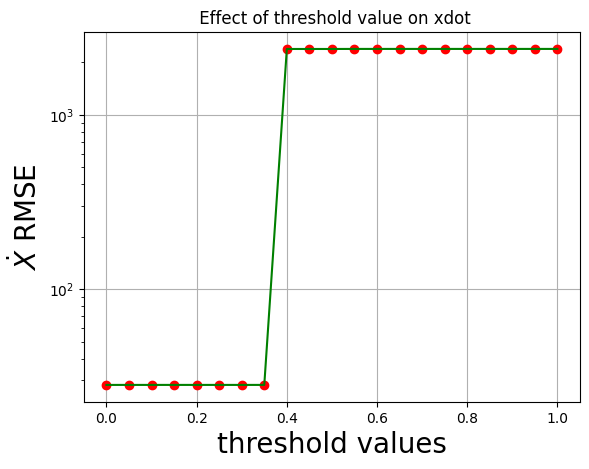

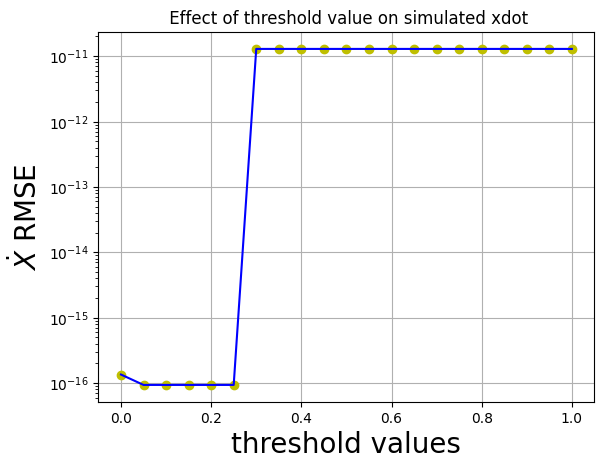

In [10]:
threshold_scan = np.arange(0.0, 1.05, 0.05)
coefs = []
rmse = mean_squared_error(data_x_train, np.zeros(data_x_train.shape), squared=False)

#x_train_added_noise = x_train + np.random.normal(0, rmse / 10.0,  x_train.shape)

for i, threshold in enumerate(threshold_scan):
    sparse_regression_optimizer = ps.STLSQ(threshold=threshold)
    model_sine = ps.SINDy(
    optimizer=sparse_regression_optimizer,
    #optimizer=sr3,
    differentiation_method= sfd,
    feature_names=["x", "xdot", "t"],
    discrete_time=False,
    feature_library=generalized_library
    )
    model_sine.fit(data_x_train, 1/sampling_rate, quiet=True)
    #model_sine.fit(data_x_train, 1/sampling_rate, ensemble=True, replace=False, n_subset=1000, n_models=3, quiet=True, unbias=False, ensemble_aggregator=np.median)
    coefs.append(model_sine.coefficients())

plot_pareto(coefs, sparse_regression_optimizer, model_sine,
            threshold_scan, data_x_train_test, t_test)

# 2. Optimizing regularization parameter 'alpha'

In [11]:
# Make coefficient plot for regularization scan
def plot_pareto(coefs, opt, model, regularization_scan, x_test, t_test):
    dt = 1/sampling_rate
    mse = np.zeros(len(regularization_scan))
    mse_sim = np.zeros(len(regularization_scan))
    for i in range(len(regularization_scan)):
        opt.coef_ = coefs[i]
        mse[i] = model.score(x_test, t=dt, metric=mean_squared_error)
        x_test_sim = model.simulate(x_test[0], t_test[:,0], integrator="odeint")
        # if np.any(x_test_sim > 1e4):
        #     x_test_sim = 1e4
        mse_sim[i] = np.sum((x_test[:,0] - x_test_sim[:, 0]) ** 2)
    
    plt.figure()
    plt.semilogy(regularization_scan, mse, "ro")
    plt.semilogy(regularization_scan, mse, "g")
    plt.title(" Effect of alpha on xdot")
    plt.ylabel(r"$\dot{X}$ RMSE", fontsize=20)
    plt.xlabel(r"$\alpha$", fontsize=20)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True)
    
    plt.figure()
    plt.semilogy(regularization_scan, mse_sim, "yo")
    plt.semilogy(regularization_scan, mse_sim, "b")
    plt.title(" Effect of alpha on simulated xdot")
    plt.ylabel(r"$\dot{X}$ RMSE", fontsize=20)
    plt.xlabel(r"$\alpha$", fontsize=20)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True)

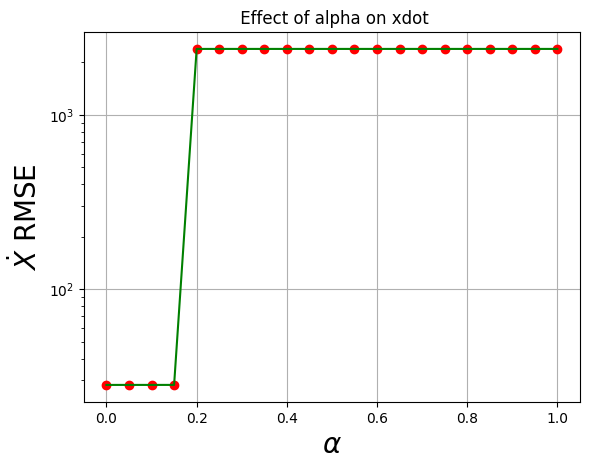

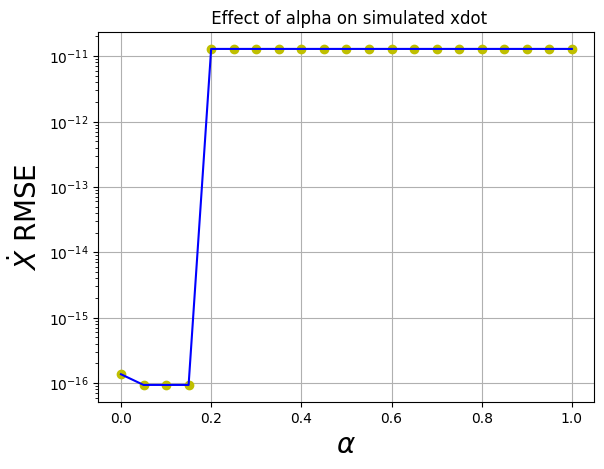

In [14]:
regularization_scan = np.arange(0, 1.05, 0.05)
coefs = []
rmse = mean_squared_error(data_x_train, np.zeros(data_x_train.shape), squared=False)

#x_train_added_noise = x_train + np.random.normal(0, rmse / 10.0,  x_train.shape)

for i, regularization in enumerate(regularization_scan):
    sparse_regression_optimizer = ps.STLSQ(threshold=0.1, alpha=regularization)
    model_sine = ps.SINDy(
    optimizer=sparse_regression_optimizer,
    #optimizer=sr3,
    differentiation_method= sfd,
    feature_names=["x", "xdot", "t"],
    discrete_time=False,
    feature_library=generalized_library
    )
    #model_sine.fit(data_x_train, 1/sampling_rate, ensemble=True, replace=False, n_subset=1000, n_models=3, quiet=True, unbias=False, ensemble_aggregator=np.median)
    model_sine.fit(data_x_train, 1/sampling_rate, quiet=True)
    coefs.append(model_sine.coefficients())

plot_pareto(coefs, sparse_regression_optimizer, model_sine,
            regularization_scan, data_x_train_test, t_test)

# 2. Optimizing 'window_size' of our diffrentiation method 'Smoothed Finite Difference'

In [15]:
# Make coefficient plot for scanning optimized window_size
def plot_pareto(coefs, opt, model, window_size, x_test, t_test):
    dt = 1/sampling_rate
    mse = np.zeros(len(window_size))
    mse_sim = np.zeros(len(window_size))
    for i in range(len(window_size)):
        opt.coef_ = coefs[i]
        mse[i] = model.score(x_test, t=dt, metric=mean_squared_error)
        x_test_sim = model.simulate(x_test[0], t_test[:,0], integrator="odeint")
        # if np.any(x_test_sim > 1e4):
        #     x_test_sim = 1e4
        mse_sim[i] = np.sum((x_test[:,0] - x_test_sim[:, 0]) ** 2)
    
    plt.figure()
    plt.semilogy(window_size, mse, "ro")
    plt.semilogy(window_size, mse, "g")
    plt.title(" Effect of window_size on xdot")
    plt.ylabel(r"$\dot{X}$ RMSE", fontsize=20)
    plt.xlabel(r"window_size", fontsize=20)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True)
    
    plt.figure()
    plt.semilogy(window_size, mse_sim, "yo")
    plt.semilogy(window_size, mse_sim, "b")
    plt.title(" Effect of window_size ")
    plt.ylabel(r"$\dot{X}$ RMSE", fontsize=20)
    plt.xlabel(r"window_size", fontsize=20)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True)

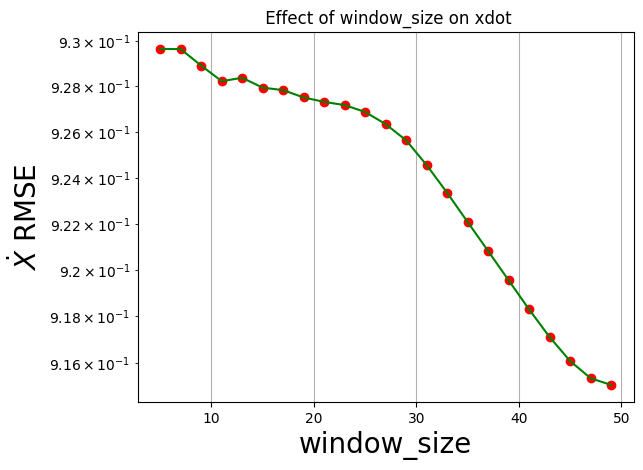

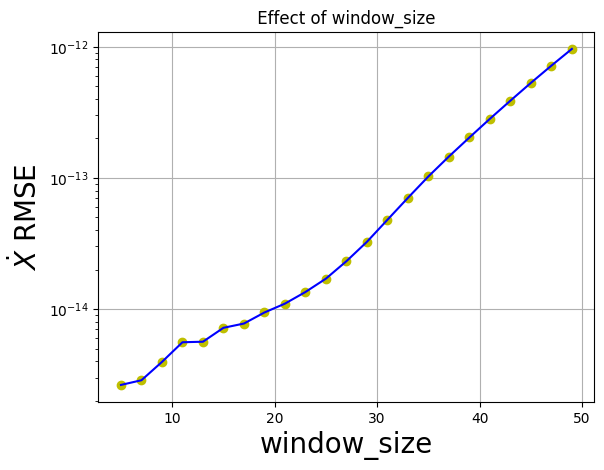

In [16]:
window_size = np.arange(5, 51, 2)
coefs = []
rmse = mean_squared_error(data_x_train, np.zeros(data_x_train.shape), squared=False)

#x_train_added_noise = x_train + np.random.normal(0, rmse / 10.0,  x_train.shape)

for i, window in enumerate(window_size):
    sparse_regression_optimizer = ps.STLSQ(threshold=0.1, alpha=0.05)
    model_sine = ps.SINDy(
    optimizer=sparse_regression_optimizer,
    #optimizer=sr3,
    differentiation_method= SmoothedFiniteDifference(smoother_kws={'window_length': window} ),
    feature_names=["x", "xdot", "t"],
    discrete_time=False,
    feature_library=generalized_library
    )
    #model_sine.fit(data_x_train, 1/sampling_rate, ensemble=True, replace=False, n_subset=1000, n_models=3, quiet=True, unbias=False, ensemble_aggregator=np.median)
    model_sine.fit(data_x_train, 1/sampling_rate, quiet=True)
    coefs.append(model_sine.coefficients())

plot_pareto(coefs, sparse_regression_optimizer, model_sine,
            window_size, data_x_train, t_train)

# Optimizing no. of iteration

In [67]:
# Make coefficient plot for threshold scan
def plot_pareto(coefs, opt, model, iteration_scan, x_test, t_test):
    dt = 1/sampling_rate
    mse = np.zeros(len(iteration_scan))
    mse_sim = np.zeros(len(iteration_scan))
    for i in range(len(iteration_scan)):
        opt.coef_ = coefs[i]
        mse[i] = model.score(x_test, t=dt, metric=mean_squared_error)
        x_test_sim = model.simulate(x_test[0], t_test[:,0], integrator="odeint")
        # if np.any(x_test_sim > 1e4):
        #     x_test_sim = 1e4
        mse_sim[i] = np.sum((x_test[:,0] - x_test_sim[:, 0]) ** 2)
    
    plt.figure()
    plt.semilogy(iteration_scan, mse, "ro")
    plt.semilogy(iteration_scan, mse, "g")
    plt.title(" Effect of No. of iteration on xdot")
    plt.ylabel(r"$\dot{X}$ RMSE", fontsize=20)
    plt.xlabel(r"No of iteration", fontsize=20)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True)
    
    plt.figure()
    plt.semilogy(iteration_scan, mse_sim, "yo")
    plt.semilogy(iteration_scan, mse_sim, "b")
    plt.title(" Effect of No. of iterationon simulated xdot")
    plt.ylabel(r"$\dot{X}$ RMSE", fontsize=20)
    plt.xlabel(r"No of iteration", fontsize=20)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True)

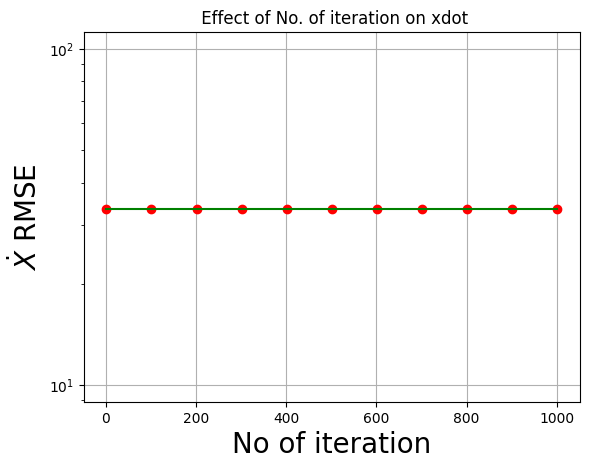

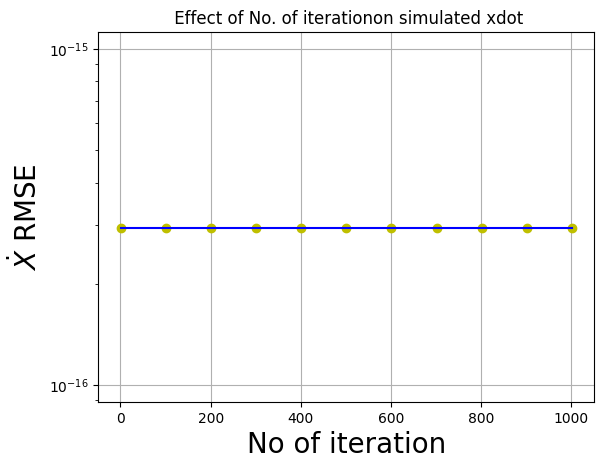

In [69]:
iteration_scan = np.arange(1, 1100, 100, dtype=int)
coefs = []
rmse = mean_squared_error(data_x_train, np.zeros(data_x_train.shape), squared=False)

#x_train_added_noise = x_train + np.random.normal(0, rmse / 10.0,  x_train.shape)

for i, iteration in enumerate(iteration_scan):
    sparse_regression_optimizer = ps.STLSQ(threshold=0.00, alpha=0, max_iter=iteration)
    model_sine = ps.SINDy(
    optimizer=sparse_regression_optimizer,
    #optimizer=sr3,
    differentiation_method= sfd,
    feature_names=["x", "xdot", "t"],
    discrete_time=False,
    feature_library=generalized_library
    )
    model_sine.fit(data_x_train, 1/sampling_rate, quiet=True)
    #model_sine.fit(data_x_train, 1/sampling_rate, ensemble=True, replace=False, n_subset=1000, n_models=3, quiet=True, unbias=False, ensemble_aggregator=np.median)
    coefs.append(model_sine.coefficients())

plot_pareto(coefs, sparse_regression_optimizer, model_sine,
            iteration_scan, data_x_train_test, t_test)

In [24]:
t_array_new = t_array
print(t_array_new.shape)

(125001, 1)


In [53]:
import numpy as np
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

window_size = 6000
start_indices = np.arange(40001, 100001, window_size)  # Start indices for each portion
errors = []
errors_p = []
for start_index in start_indices:
    end_index = start_index + window_size
    portion_sig =displacement[start_index:end_index]
    portion_time = t_array_new[start_index:end_index]
    portion_xdot = sfd._differentiate(portion_sig, portion_time[:, 0] )
    data_x_train_new = np.hstack((portion_sig, portion_xdot, portion_time))
    model_sine=ps.SINDy(
    optimizer=stlsq,
    #optimizer=ensemble_optimizer,
    #optimizer=sr3,
    differentiation_method= sfd,
    # differentiation_method=diff,
    feature_names=["x", "xdot", "t"],
    discrete_time=False,
    feature_library=generalized_library 
    )
    model_sine.fit(data_x_train_new, 1/sampling_rate)
    
    sim_new = model_sine.simulate(np.array(data_x_train_new[0]), portion_time[:, 0], integrator="odeint") 
    # Calculate and store the error metrics of each portion

    error = r2_score(data_x_train_new[:, 0], sim_new[:, 0])
    error_p = pearsonr(data_x_train_new[:, 0], sim_new[:, 0])
    errors.append(error)
    errors_p.append(error_p)
    
    print(f"Start index: {start_index}, Error: {error, error_p}")

C:\Users\sayee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(


Start index: 40001, Error: (0.9992330642196365, PearsonRResult(statistic=0.9996351824167145, pvalue=0.0))
Start index: 46001, Error: (0.9997055492430533, PearsonRResult(statistic=0.999883048897795, pvalue=0.0))
Start index: 52001, Error: (0.9994377528550097, PearsonRResult(statistic=0.9997270550311737, pvalue=0.0))
Start index: 58001, Error: (0.9994589033897884, PearsonRResult(statistic=0.9997486047414729, pvalue=0.0))


C:\Users\sayee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(


Start index: 64001, Error: (0.9993396044297567, PearsonRResult(statistic=0.9996703728496846, pvalue=0.0))
Start index: 70001, Error: (0.9992610576811749, PearsonRResult(statistic=0.9996452696510575, pvalue=0.0))
Start index: 76001, Error: (0.9995059943014621, PearsonRResult(statistic=0.9997535442982066, pvalue=0.0))
Start index: 82001, Error: (0.9995589987768059, PearsonRResult(statistic=0.9997972298872866, pvalue=0.0))
Start index: 88001, Error: (0.9993920233643153, PearsonRResult(statistic=0.9996975380082962, pvalue=0.0))
Start index: 94001, Error: (0.9995293344935087, PearsonRResult(statistic=0.9997657266652691, pvalue=0.0))


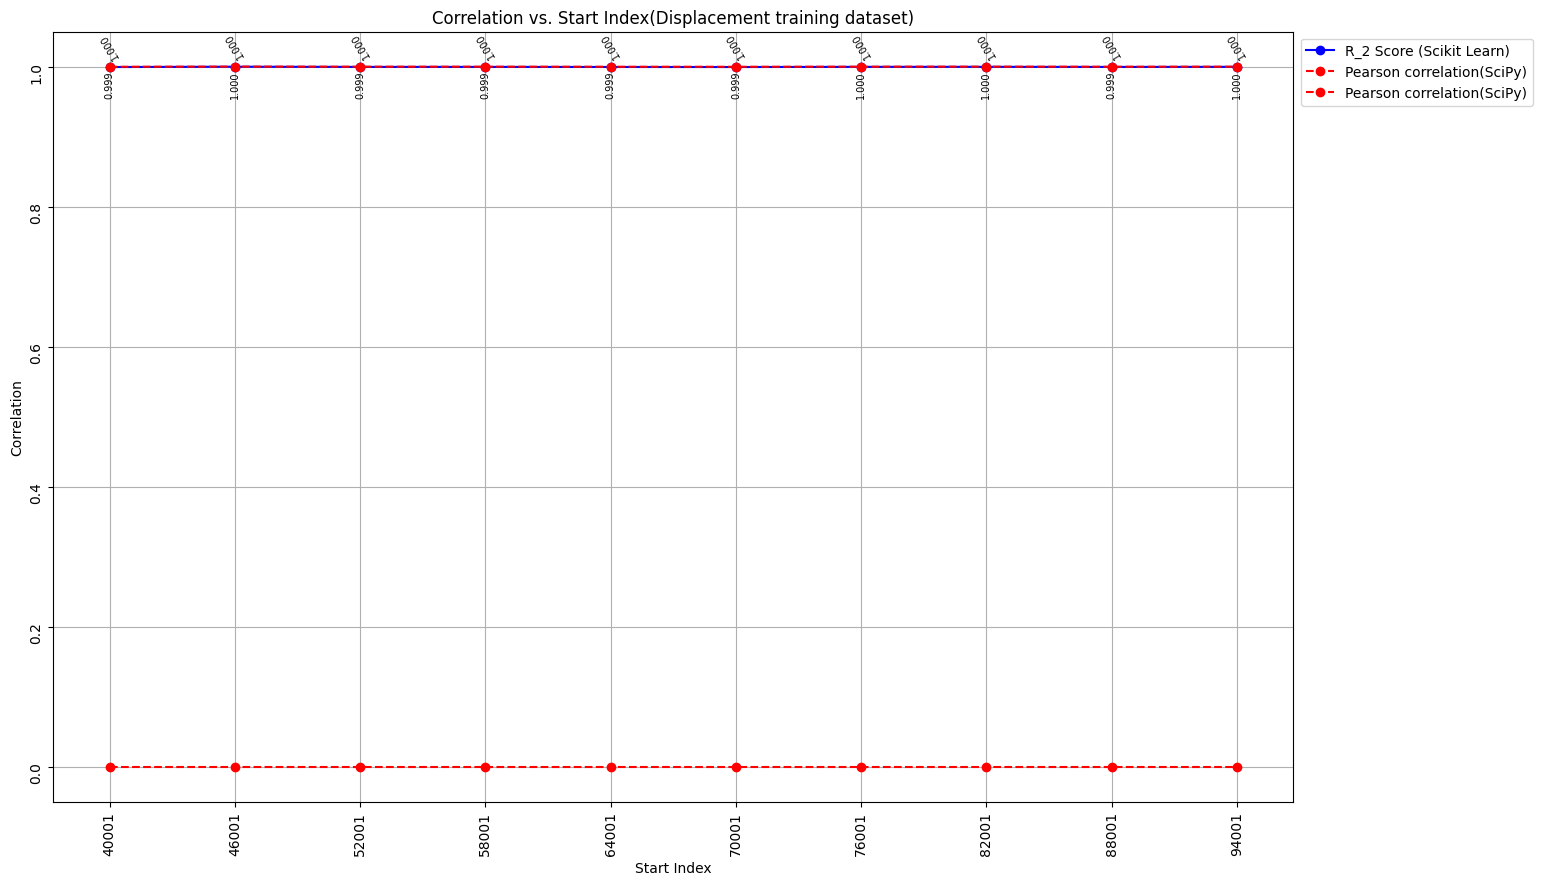

In [54]:
#from matplotlib.offsetbox import offset_copy
# Plotting the errors
plt.figure(figsize=(16, 10))
plt.xlabel('Start Index')
#plt.ylim(0.8, 1)
plt.ylabel('Correlation')
plt.title('Correlation vs. Start Index(Displacement training dataset)', loc='center')
plt.xticks(start_indices, fontsize=10, rotation=90)
plt.yticks(fontsize=10, rotation=90)

# Plot the configurations and scores
plt.plot(start_indices, errors, marker='o', linestyle='-', color='b', label="R_2 Score (Scikit Learn)")
plt.plot(start_indices, errors_p, marker='o', linestyle='--', color='r', label="Pearson correlation(SciPy)")

plt.grid(True)

plt.legend(loc='upper left',  bbox_to_anchor=(1.0005, 1))

for x, score in zip(start_indices, errors):
    score_value = score
    text = "{:.3f}".format(score_value)
    text_y = score_value - 0.0055  # Adjust the y-coordinate for positioning
    plt.text(x, text_y, text, ha='center', va='top', fontsize=7, rotation=90)


for x, corr in zip(start_indices, errors_p):
    corr_value = corr[0]  # Extract the first value (correlation)
    text = "{:.3f}".format(corr_value)
    text_y = corr_value + 0.01  # Adjust the y-coordinate for positioning
    plt.text(x, text_y, text, ha='center', va='bottom', fontsize=7, rotation=120)
plt.show()

In [55]:
import numpy as np
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

window_size =3000
start_indices = np.arange(100001, 112001, window_size)  # Start indices for each portion
errors = []
errors_p = []
for start_index in start_indices:
    end_index = start_index + window_size
    portion_sig = displacement[start_index:end_index]
    portion_time = t_array_new[start_index:end_index]
    portion_xdot = sfd._differentiate(portion_sig, portion_time [:, 0])
    data_x_train_new = np.hstack((portion_sig, portion_xdot, portion_time))

    
    sim_new = model_sine.simulate(np.array(data_x_train_new[0]), portion_time[:, 0], integrator="odeint") 
    # Calculate and store the error metrics of each portion

    error = r2_score(data_x_train_new[:, 0], sim_new[:, 0])
    error_p = pearsonr(data_x_train_new[:, 0], sim_new[:, 0])
    errors.append(error)
    errors_p.append(error_p)
    
    print(f"Start index: {start_index}, Error: {error, error_p}")

Start index: 100001, Error: (0.9999026706808244, PearsonRResult(statistic=0.9999580558378267, pvalue=0.0))
Start index: 103001, Error: (0.9998165946192397, PearsonRResult(statistic=0.9999084043268103, pvalue=0.0))
Start index: 106001, Error: (0.9997331300961592, PearsonRResult(statistic=0.9998668912609125, pvalue=0.0))
Start index: 109001, Error: (0.9997494118952186, PearsonRResult(statistic=0.9998878145987523, pvalue=0.0))


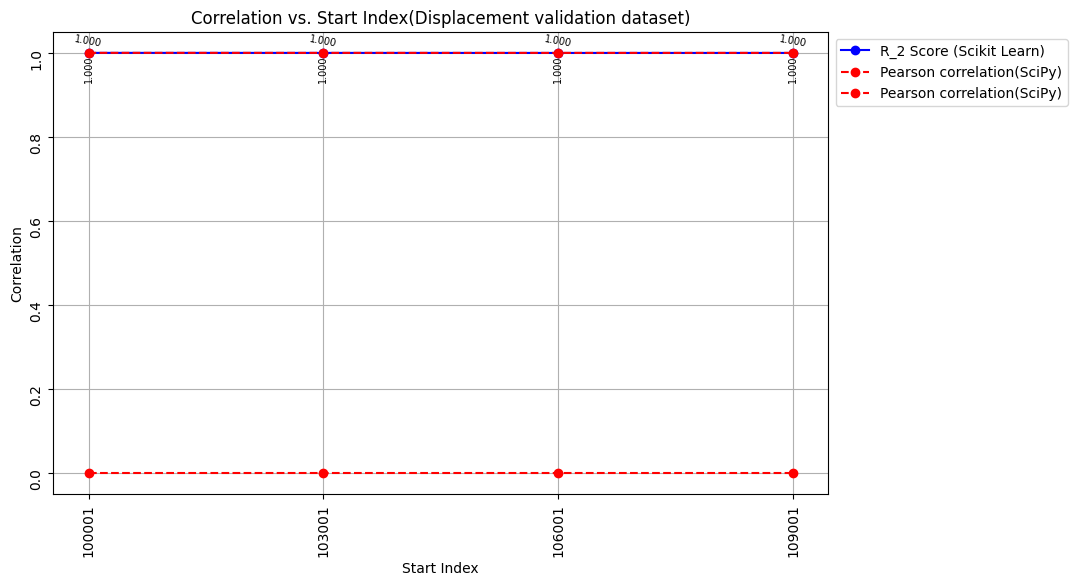

In [56]:
#from matplotlib.offsetbox import offset_copy
# Plotting the errors
plt.figure(figsize=(10, 6))
plt.xlabel('Start Index')
#plt.ylim(0.8, 1)
plt.ylabel('Correlation')
plt.title('Correlation vs. Start Index(Displacement validation dataset)', loc='center')
plt.xticks(start_indices, fontsize=10, rotation=90)
plt.yticks(fontsize=10, rotation=90)

# Plot the configurations and scores
plt.plot(start_indices, errors, marker='o', linestyle='-', color='b', label="R_2 Score (Scikit Learn)")
plt.plot(start_indices, errors_p, marker='o', linestyle='--', color='r', label="Pearson correlation(SciPy)")

plt.grid(True)

plt.legend(loc='upper left',  bbox_to_anchor=(1.0005, 1))

for x, score in zip(start_indices, errors):
    score_value = score
    text = "{:.3f}".format(score_value)
    text_y = score_value - 0.0055  # Adjust the y-coordinate for positioning
    plt.text(x, text_y, text, ha='center', va='top', fontsize=7, rotation=90)


for x, corr in zip(start_indices, errors_p):
    corr_value = corr[0]  # Extract the first value (correlation)
    text = "{:.3f}".format(corr_value)
    text_y = corr_value + 0.01  # Adjust the y-coordinate for positioning
    plt.text(x, text_y, text, ha='center', va='bottom', fontsize=7, rotation=-10)
plt.show()